In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install stellargraph

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

import networkx as nx
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph
from stellargraph import datasets

# Carga de datos

In [ ]:
from zipfile import ZipFile 

path = "/content/drive/My Drive/Colab Notebooks/Redes Neuronales/data_taller_2/taller2ann-usm.zip"

with ZipFile(path, 'r') as zip: 
    print('Extrayendo datos...') 
    zip.extractall()
    print('Listo!') 

Extrayendo datos...
Listo!


In [ ]:
train_labels = pd.read_csv('/content/train_labels.csv')
train_source = pd.read_fwf('/content/train_source_tweets.txt', header=None)
train_source.columns = ["id", "text"]
train_labels['text'] = train_source['text'] 
sent_to_id = {"false":0, "non-rumor":1, "true":2, "unverified":3}
train_labels["label_id"] = train_labels['label'].map(sent_to_id)
train_labels

,label,id,text,label_id
0,non-rumor,692735698349199360,north korea 'planning some kind of rocket laun...,1
1,unverified,525008463819464704,"meet kevin vickers, the hero who shot down the...",3
2,false,505611045897924608,"15 year old who ""swatted"" gamer convicted of d...",0
3,non-rumor,693466724822323200,audio recordings reveal cpr started 11 minutes...,1
4,true,510922415468449792,awful mt @scclemons:uk aid worker david haines...,2
...,...,...,...,...
1921,true,515598200796090369,#workplace hero shoots #altonnolen #stabbings ...,2
1922,unverified,535257207991205888,russian boy shocked by electricity now claims ...,3
1923,true,524944399890124801,recap: gunman shot dead inside parliament buil...,2
1924,false,519965814175567872,a vandal painted a brilliantly simple penis on...,0


In [ ]:
def get_dataframe(tweet_id):
    tweet = open('/content/train/'+str(tweet_id)+'.txt', 'rb')
    lists = [[],[],[],[],[],[]]
    for linea in tweet:
        simb = ['[',']','->','b"','"',',','r','n','\\']
        for s in simb:
            linea = str(linea).replace(s,'')
        linea = str(linea).replace("''",' ')
        linea = str(linea).replace("'",'')
        for i in range(6):
            lists[i].append(linea.split()[i])
    lists[0][0] = 0
    lists[1][0] = 0
    df = pd.DataFrame()
    df['p_user_id'] = list(map(lambda x: float(x) if x != 'ROOT' else 0, lists[0]))
    df['p_tw_id'] = list(map(lambda x: float(x) if x != 'ROOT' else 0, lists[1]))
    df['p_time'] = list(map(lambda x: float(x), lists[2]))
    df['c_user_id'] = list(map(lambda x: float(x), lists[3]))
    df['c_tw_id'] = list(map(lambda x: float(x), lists[4]))
    df['c_time'] = list(map(lambda x: float(x), lists[5]))
    return df

# Grafo

In [ ]:
graphs = []
for k, id_tweet in enumerate(train_labels['id']):
    print(k)
    df = get_dataframe(id_tweet)
    df = df.loc[:round(df.shape[0]*0.2)]
    aux1 = pd.DataFrame()
    aux1['user_id'] = df['p_user_id']
    aux1['tw_id'] = df['p_tw_id']
    aux2 = pd.DataFrame()
    aux2['user_id'] = df['c_user_id']
    aux2['tw_id'] = df['c_tw_id']
    node_data =  aux1.append(aux2,ignore_index=True)
    node_data = node_data.drop_duplicates()
    node_data = node_data.reset_index(drop=True)
    edge_data = pd.DataFrame(columns=['source','target','A','B'])
    for i in range(df.shape[0]):
        index1 = node_data[(node_data['user_id'] == df['p_user_id'][i]) & (node_data['tw_id'] == df['p_tw_id'][i])].index[0]
        index2 = node_data[(node_data['user_id'] == df['c_user_id'][i]) & (node_data['tw_id'] == df['c_tw_id'][i])].index[0]
        edge_data.loc[edge_data.shape[0]+1] = [index1, index2, df['p_time'][i], df['c_time'][i]]

    graph = StellarGraph({'corner':node_data},{'line':edge_data[['source','target']]})
    graphs.append(graph)

generator = PaddedGraphGenerator(graphs=graphs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 120, Edges: 119

 Node types:
  corner: [120]
    Features: float32 vector, length 2
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [119]
        Weights: all 1 (default)
        Features: none


In [ ]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,1926.0,1926.0
mean,86.7,87.8
std,87.9,90.0
min,13.0,12.0
25%,34.0,34.0
50%,58.0,57.0
75%,100.0,102.0
max,624.0,630.0


In [ ]:
train_labels['label_id'].value_counts().to_frame()

,label_id
1,524
0,520
2,514
3,368


In [ ]:
graph_labels = pd.get_dummies(train_labels['label_id'], drop_first=False)
graph_labels.head()

,0,1,2,3
0,0,1,0,0
1,0,0,0,1
2,1,0,0,0
3,0,1,0,0
4,0,0,1,0


# Modelo

In [ ]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=2, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.2)(x_out)

predictions = Dense(units=4, activation="softmax")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=Adam(lr=0.01), loss=categorical_crossentropy, metrics=["acc"],
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, None, 2)      0           input_7[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None, None)] 0                                            
__________________________________________________________________________________________________
graph_convolution_8 (GraphConvo (None, None, 32)     64          dropout_10[0][0]                 
                                                                 input_9[0][0]              

In [ ]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.8, test_size=None, stratify=graph_labels,
)

In [ ]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=64,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

In [ ]:
epochs = 10
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


25/25 [==============================] - 11s 448ms/step - loss: 1.8971 - acc: 0.2636 - val_loss: 1.3816 - val_acc: 0.2746
Epoch 2/10
25/25 [==============================] - 11s 438ms/step - loss: 1.3998 - acc: 0.2682 - val_loss: 1.3852 - val_acc: 0.2591
Epoch 3/10
25/25 [==============================] - 11s 443ms/step - loss: 1.3899 - acc: 0.2571 - val_loss: 1.3787 - val_acc: 0.2539
Epoch 4/10
25/25 [==============================] - 11s 451ms/step - loss: 1.3817 - acc: 0.2701 - val_loss: 1.3790 - val_acc: 0.2720
Epoch 5/10
25/25 [==============================] - 11s 446ms/step - loss: 1.3780 - acc: 0.2721 - val_loss: 1.3772 - val_acc: 0.2720
Epoch 6/10
25/25 [==============================] - 11s 436ms/step - loss: 1.3772 - acc: 0.2721 - val_loss: 1.3785 - val_acc: 0.2720
Epoch 7/10
25/25 [==============================] - 11s 442ms/step - loss: 1.3776 - acc: 0.2792 - val_loss: 1.3792 - val_acc: 0.2617
Epoch 8/10
25/25 [==============================] - 11s 441ms/step - loss: 1.377

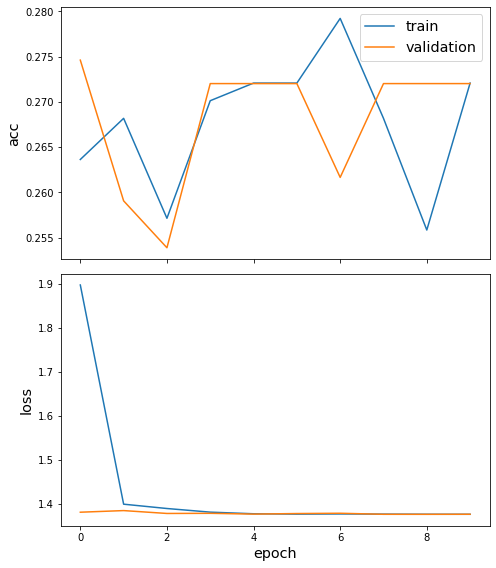

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_metrics = model.evaluate(test_gen)
print(f"Test metrics:\nLoss: {test_metrics[0]}\nAccuracy: {test_metrics[1]}")

386/386 [==============================] - 1s 2ms/step - loss: 1.3769 - acc: 0.2720
Test metrics:
Loss: 1.376928448677063
Accuracy: 0.27202072739601135


In [ ]:
model.predict(test_gen)

array([[0.26796156, 0.2806955 , 0.2664465 , 0.18489645],
       [0.26796156, 0.2806955 , 0.2664465 , 0.18489645],
       [0.26796156, 0.2806955 , 0.2664465 , 0.18489645],
       ...,
       [0.26796156, 0.2806955 , 0.2664465 , 0.18489645],
       [0.26796156, 0.2806955 , 0.2664465 , 0.18489645],
       [0.26796156, 0.2806955 , 0.2664465 , 0.18489645]], dtype=float32)